In [2]:
# system
import glob
import time
import os
import logging
import sys

# scipy
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit

# matplotlib
import matplotlib
import matplotlib.pyplot as plt

# grandlib
import grand.dataio.root_trees as rt

import tools


%matplotlib inline
plt.style.use('/pbs/home/p/pcorrea/tools/matplotlib_style_sans-serif.txt')

Welcome to JupyROOT 6.26/10


In [14]:
sig_dir   = '/sps/grand/pcorrea/nutrig/database/sig/zhaires_proton_rfv2/'
sig_files = sorted( glob.glob( os.path.join(sig_dir,'*.npz') ) )

In [16]:
snr        = np.zeros(0)
file_idx   = np.zeros(0)
file_entry = np.zeros(0)

for i, sig_file in enumerate(sig_files[::10]):
    with np.load(sig_file) as f:
        mask_trig = np.where(f['pretrig_flags']==0,False,True)
        snr_new   = np.max(f['snr'][...,:2],axis=1) # SNR of event = maximum of X/Y SNR (= where you triggered)
        mask_snr  = np.where(snr_new<10,True,False)
        
        mask  = np.logical_and(mask_snr,mask_trig)

        if np.any(mask):
            entries_mask   = np.arange( len(mask) )[mask]
            n_entries_mask = len( mask[mask] )

            snr        = np.hstack( ( snr, snr_new[mask] ) )
            file_idx   = np.hstack( ( file_idx, i*np.ones(n_entries_mask) ) )
            file_entry = np.hstack( ( file_entry, entries_mask ) )

#return snr, file_idx, file_entry

In [4]:
snr = np.zeros((0,3))
inj_time = np.zeros(0)
trig_time = np.zeros(0)
trig_flag = np.zeros(0)
energy = np.zeros(0)

max_traces = np.zeros((0,3))

for sig_file in sig_files[::5]:
    with np.load(sig_file) as f:
        mask_trig = np.where(f['pretrig_flags']==0,False,True)

        snr = np.vstack((snr,f['snr'][mask_trig]))
        inj_time = np.hstack((inj_time,f['inj_pulse_times'][mask_trig]))
        trig_time = np.hstack((trig_time,f['pretrig_times'][mask_trig]))
        trig_flag = np.hstack((trig_flag,f['pretrig_flags'][mask_trig]))

        rms = tools.rms(f['traces'][mask_trig],axis=2)
        max_trace = np.max(np.abs(f['traces'][mask_trig]),axis=2)

        max_traces = np.vstack((max_traces,max_trace/rms))

        energy_sim = float(os.path.basename(sig_file).split('_')[7]) * np.ones(mask_trig[mask_trig].shape)
        energy = np.hstack((energy,energy_sim))

weights_energy = ( energy/np.min(energy) )**-3

<BarContainer object of 399 artists>

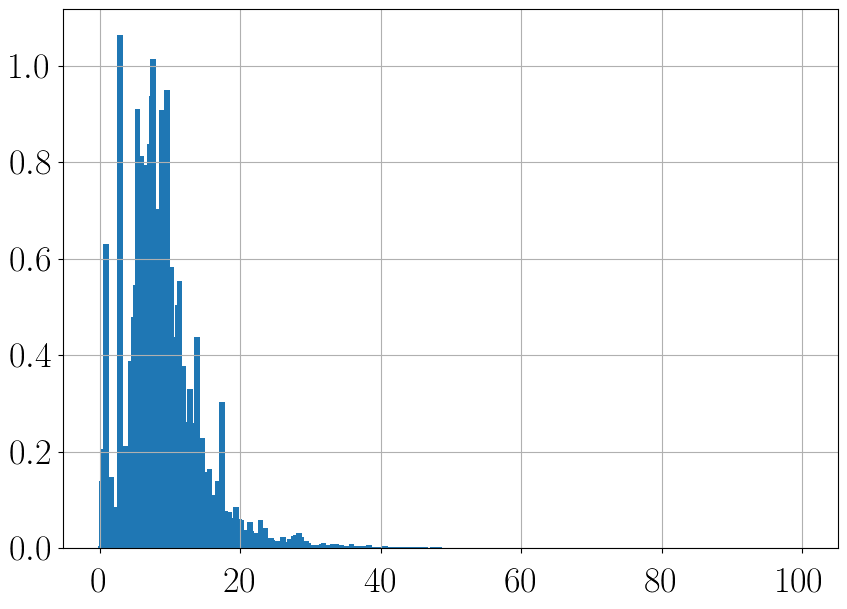

In [5]:
bin_edges   = np.arange(0,100,.25)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.

mask_x = np.logical_or(trig_flag==1,trig_flag==12)
mask_y = np.logical_or(trig_flag==2,trig_flag==12)

hist_x,_ = np.histogram(snr[:,0][mask_x],bins=bin_edges,weights=weights_energy[mask_x])
hist_y,_ = np.histogram(snr[:,1][mask_y],bins=bin_edges,weights=weights_energy[mask_y])


# plt.hist(snr[:,0][mask_x],bins=bins,color='b')
# plt.xlim([3,8])
# plt.show()
# plt.hist(snr[:,1][mask_y],bins=bins,color='m')
# plt.xlim([3,8])
# plt.show()

plt.bar(bin_centers,hist_x+hist_y)
#plt.xlim([3,8])
#plt.ylim([0,4000])
#plt.axhline(8020/20/5,color='r')
#hist_x+hist_y

(3.0, 8.0)

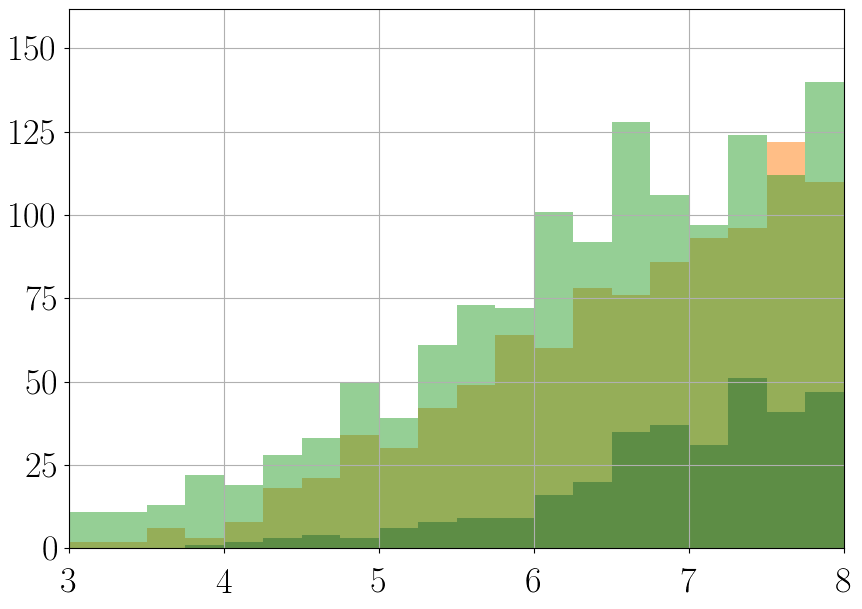

In [6]:
snr_xy_min = np.where( snr[:,0][trig_flag==12] < snr[:,1][trig_flag==12], snr[:,0][trig_flag==12], snr[:,1][trig_flag==12] )
snr_xy_max = np.where( snr[:,0][trig_flag==12] > snr[:,1][trig_flag==12], snr[:,0][trig_flag==12], snr[:,1][trig_flag==12] )

hist,_ = np.histogram(snr_xy_max,bins=bin_edges)
plt.bar(bin_centers,hist,width=.25)
hist,_ = np.histogram(snr[:,0][trig_flag==12],bins=bin_edges)
plt.bar(bin_centers,hist,alpha=.5,width=.25)
hist,_ = np.histogram(snr[:,1][trig_flag==12],bins=bin_edges)
plt.bar(bin_centers,hist,alpha=.5,width=.25)
# hist,_ = np.histogram(np.max( snr[:,0][trig_flag==12],snr[:,1][trig_flag==12] ),bins=bin_edges)
# plt.bar(bin_centers,hist)
plt.xlim([3,8])

In [7]:
entries    = np.arange(len(snr))
entries_x  = entries[trig_flag==1]
entries_y  = entries[trig_flag==2]
entries_xy = entries[trig_flag==12]

snr_hist = np.max( snr[:,:2],axis=1 )
snr_hist = np.where(snr_hist==0,100,snr_hist)

[-0.0939123  -0.23190971] [[0.00504423        nan]
 [       nan 0.0727184 ]]


/scratch/users/p/pcorrea/ipykernel_16943/806492135.py:14: RuntimeWarning: invalid value encountered in sqrt
  print(pbest,np.sqrt(pcov))


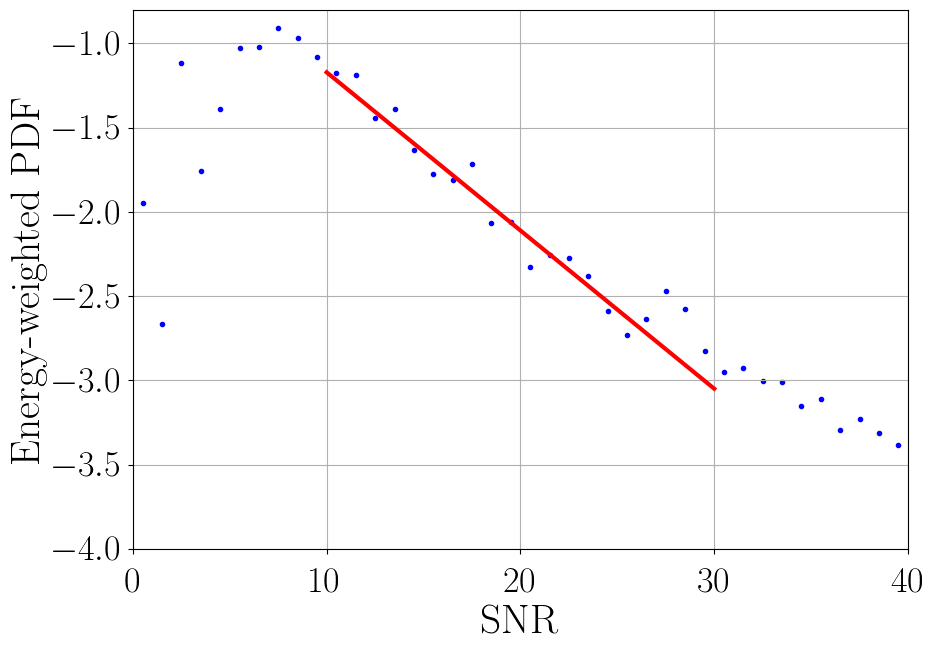

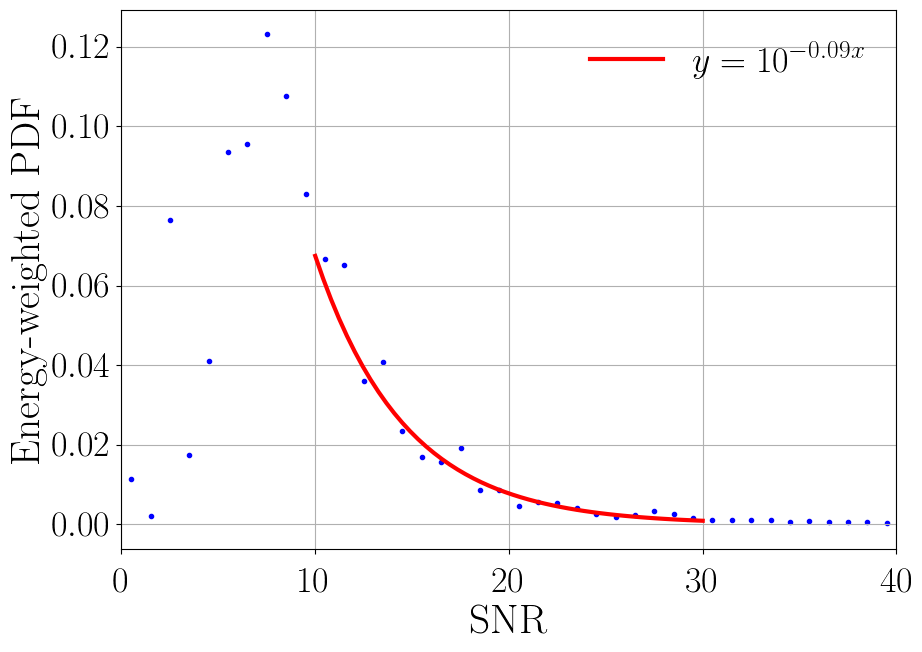

In [8]:
def fit_func(x,a,b):
    return a*x + b


bins = np.arange(0,100)
bin_centers = (bins[1:] + bins[:-1])/2

hist,_ = np.histogram(snr_hist,bins=bins,weights=weights_energy,density=True)
log_hist = np.log10(hist)

pbest, pcov = curve_fit(fit_func,bins[10:30],log_hist[10:30],sigma=1/np.sqrt(hist[10:30]))
fit_label   = r'$y = 10^{' + '{:.2f}'.format(pbest[0]) + r'x}$'

print(pbest,np.sqrt(pcov))

fig, ax = plt.subplots()

ax.scatter(bin_centers,log_hist,color='b')

x = np.linspace(10,30)
ax.plot(x,fit_func(x,pbest[0],pbest[1]),color='r')

ax.set_xlim([0,40])
ax.set_ylim([-4,-.8])

ax.set_xlabel('SNR')
ax.set_ylabel('Energy-weighted PDF')

plt.show()


fig, ax = plt.subplots()

ax.scatter(bin_centers,hist,color='b')

x = np.linspace(10,30)
ax.plot(x,10**fit_func(x,pbest[0],pbest[1]),color='r',label=fit_label)

ax.set_xlim([0,40])

ax.set_xlabel('SNR')
ax.set_ylabel('Energy-weighted PDF')

ax.legend()

plt.show()

In [9]:
bin_width = .25
bin_edges = np.arange(3.,8.25,bin_width)
which_bin = np.digitize(snr_hist,bins=bin_edges)

idcs_sorted      = np.argsort(which_bin)
entries_sorted   = entries[idcs_sorted] #entries_snr[idcs_sorted]
which_bin_sorted = which_bin[idcs_sorted]
# weights_sorted   = weights_energy[idcs_sorted]

mask_hist      = np.logical_and(which_bin_sorted!=0,which_bin_sorted!=len(bin_edges))
entries_hist   = entries_sorted[mask_hist]
which_bin_hist = which_bin_sorted[mask_hist]

bin_numbers, bin_idcs, bin_counts = np.unique(which_bin_hist,return_index=True,return_counts=True)

In [10]:
bin_weights  = 10**(-0.09*bin_edges[:-1])
bin_weights /= bin_weights.sum()

n_tot = 8020/5

n_per_bin = n_tot*bin_weights
n_per_bin = n_per_bin.astype(int)

diff = int( n_tot - n_per_bin.sum() )
n_per_bin[:diff] += 1

n_bins = len(n_per_bin)

print(n_per_bin.sum(),bin_weights)


# n_per_bin = int( n_tot/bin_numbers.size )*np.ones(bin_numbers.size,dtype=int)

# diff = int( 8020/5 - np.sum(n_per_bin) )
# n_per_bin[:diff] += 1
# print(n_per_bin)


entries_rand = np.zeros(0,dtype=int)
for i in range(len(bin_numbers)):
    entry_idx_start = bin_idcs[i]
    entry_idx_end   = bin_idcs[i]+bin_counts[i]
    idcs_for_choice = np.arange(entry_idx_start,entry_idx_end)

    if len(idcs_for_choice) < n_per_bin[i]:
        n_missing            = n_per_bin[i] - len(idcs_for_choice)
        n_tot_compensate     = np.sum(n_per_bin[i+1:]) + n_missing
        n_compensate_per_bin = n_missing * (bin_weights[i+1:]/bin_weights[i+1:].sum())

        n_per_bin[i+1:] += n_compensate_per_bin.astype(int)
        diff = int( n_tot_compensate - np.sum(n_per_bin[i+1:])  )

        n_per_bin[i+1:i+1+diff] += 1
        n_per_bin[i] = len(idcs_for_choice)
        print(n_per_bin)
        entries_rand = np.hstack( (entries_rand,entries_hist[idcs_for_choice]) )
    else:
        #weights_bin = weights_sorted[entry_idx_start:entry_idx_end]
        idcs_rand = np.random.choice( idcs_for_choice,size=n_per_bin[i],replace=False) #p=weights_bin/weights_bin.sum()
        entries_rand = np.hstack( (entries_rand,entries_hist[idcs_rand]) )

print(n_per_bin)

1604 [0.07825488 0.07430387 0.07055234 0.06699022 0.06360795 0.06039645
 0.0573471  0.0544517  0.05170249 0.04909208 0.04661347 0.04426
 0.04202536 0.03990354 0.03788885 0.03597588 0.03415949 0.03243482
 0.03079721 0.02924229]
[ 24 129 122 116 111 104  99  95  89  85  80  74  71  68  64  60  57  55
  52  49]
[ 24  29 131 124 119 112 106 102  96  91  86  79  75  72  68  64  61  58
  55  52]
[ 24  29  31 133 128 120 114 110 103  98  93  84  80  77  72  68  65  62
  58  55]
[ 24  29  31  40 137 128 122 118 110 105 100  90  85  82  76  72  69  66
  62  58]
[ 24  29  31  40  47 137 130 126 118 112 107  97  90  87  81  77  73  70
  66  62]
[ 24  29  31  40  47  74 137 132 124 118 113 102  94  91  85  80  76  73
  69  65]
[ 24  29  31  40  47  74  92 137 129 123 117 106  98  95  88  83  78  75
  71  67]
[ 24  29  31  40  47  74  92 116 132 126 120 108 100  97  89  84  79  76
  72  68]
[ 24  29  31  40  47  74  92 116 132 126 120 108 100  97  89  84  79  76
  72  68]


In [11]:
len(snr_hist[np.logical_and(snr_hist>=3,snr_hist<4)])

124

(2.5, 8.5)

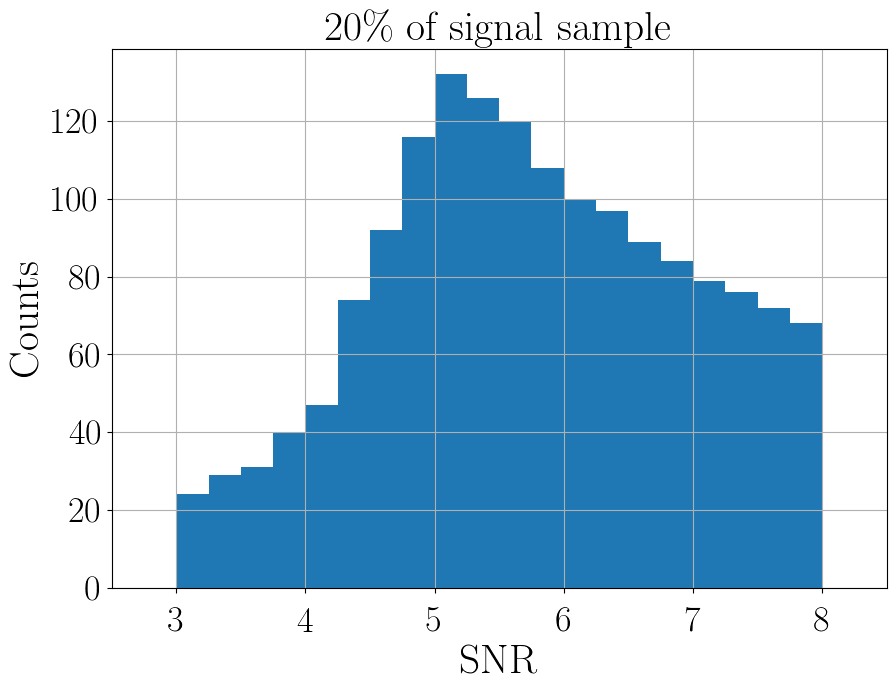

In [12]:
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
plt.hist(snr_hist[entries_rand],bins=bin_edges)
plt.bar(bin_centers,n_per_bin,width=bin_width)
plt.xlabel('SNR')
plt.ylabel('Counts')
plt.title(r'20\% of signal sample')
plt.xlim([2.5,8.5])
#plt.yscale('log')